# Anomalies in Time Series Data


- Continuous or discrete target variable: Continuous  
- Point in time or time series: Time series  
- Predict values or detect anomalies: Detect Anomalies   

_____________________________

Is this new value something to be concerned about? Does it deviate from what we would expect based on historical data? 

In this lesson we will walk through ways to identify these anomalies using statistics. 

- Flag the data points that deviate from the expected using statistical properties that represent measures of central tendency, such as mean, median and mode.   
- Use measures of spread, such as standard deviation, to find those points with extreme deviation from the mean of a normally distributed continuous variable.   
- Use the simple or exponential moving average to smooth short-term fluctuations and highlight long-term ones can help reduce some of the noise and draw out extreme outliers.    

The example scenario for this lesson:  

> Detect anomalies in the amount of data consumed by users accessing the store-items data using zach's api. 

## Wrangle Data

**Prepare Environment**

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn import metrics

from scipy.stats import entropy

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates #to format dates on our plots
%matplotlib inline
import seaborn as sns

# This is to make sure matplotlib doesn't throw the following error:
# The next line fixes "TypeError: float() argument must be a string or a number, not 'Timestamp' matplotlib"
pd.plotting.register_matplotlib_converters()


**Acquire**

Our data: logs of activity occurring on the server that hosts Codeup curriculum.  

After doing some research, some experimentation of performing actions and watching the logs, we discovered what each of the field represent. We then parse and name the fields accordingly. 

In [2]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('https://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

In [3]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13974 entries, 0 to 13973
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ip              13974 non-null  object
 1   timestamp       13974 non-null  object
 2   request_method  13974 non-null  object
 3   status          13974 non-null  int64 
 4   size            13974 non-null  int64 
 5   destination     25 non-null     object
 6   request_agent   13974 non-null  object
dtypes: int64(2), object(5)
memory usage: 764.3+ KB


We are now going to fabricate some anomalous observations for demonstration purposes as we work through the lesson. 

In [4]:
new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [5]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


**Takeaways**

- timestamp: Remove square brackets, replace the first colon (after dd/MM/yyyy) with a space so we can then convert to datetime dtype, convert to datetime, set as index.  
- request_method: Remove quotation marks and '?page=x', we may want to split request_method so the we have another columns with the request type (GET, PUT, ...). We'll wait and see if we want to use it.  
- request_agent: Remove quotation marks.  
- size: Convert to MB, purely to put the values in smaller number and units we are more accustomed to seeing.  

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13978 entries, 0 to 3
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ip              13978 non-null  object
 1   timestamp       13978 non-null  object
 2   request_method  13978 non-null  object
 3   status          13978 non-null  int64 
 4   size            13978 non-null  int64 
 5   destination     25 non-null     object
 6   request_agent   13978 non-null  object
dtypes: int64(2), object(5)
memory usage: 873.6+ KB


**Takeaways**

- The fact that destination is mostly null with a few non-nulls gives alert to possible anomalies.  
- Convert timestamp to datetime.  
- Once we remove destination, there will be no remaining missing values.  


**Clean Timestamp**

- Remove square brackets.   
- Replace the first colon (after dd/mm/yyyy) with a space so we can then convert to datetime dtype.  
- Convert to datetime.    

In [7]:
df.timestamp = df.timestamp.str.replace(r'(\[|\])', '', regex=True)
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1)) 
df = df.set_index('timestamp')

In [8]:
df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:42+00:00,97.105.19.58,"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:44+00:00,97.105.19.58,"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:46+00:00,97.105.19.58,"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:48+00:00,97.105.19.58,"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


**Cleanup Strings**

- Remove quotation marks and '?page=x' from request_method.  
- Remove quotation marks from request_agent.  

In [9]:
df.destination.value_counts()

"https://python.zach.lol/"                                        4
"https://ds.codeup.com/8.3_Acquire/"                              3
"https://python.zach.lol/api/v1/stores?page=1"                    2
"https://python.zach.lol/api/v1/"                                 2
"https://python.zach.lol/api/v1/stores?page=999"                  1
"https://python.zach.lol/api/v1/stores?page=0"                    1
"https://python.zach.lol/api/v1/helloclass!"                      1
"https://python.zach.lol/api/v1/items?page=0"                     1
"https://python.zach.lol/api/V1/HiZach!"                          1
"https://python.zach.lol/api/v1//api/v1/items"                    1
"https://python.zach.lol/api/v1/I_DIDNT_DO_IT!!!!"                1
"http://localhost:8888/notebooks/acquire.ipynb"                   1
"http://localhost:8889/notebooks/timeseries_acquisition.ipynb"    1
"https://python.zach.lol/api/v1/items"                            1
"https://python.zach.lol/api/v1/sales?page=3"   

In [10]:
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

In [11]:
len(df.request_method.value_counts())

220

In [12]:
df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex = True)

In [13]:
len(df.request_method.value_counts())

22

In [14]:
df.request_method.value_counts()

GET /api/v1/sales HTTP/1.1                      12403
GET /api/v1/items HTTP/1.1                       1065
GET /api/v1/stores HTTP/1.1                       229
GET / HTTP/1.1                                    107
GET /documentation HTTP/1.1                       100
GET /favicon.ico HTTP/1.1                          26
GET /api/v1//api/v1/items HTTP/1.1                 11
GET /api/v1/items/api/v1/items HTTP/1.1             7
GET /api/v1/items/next_page HTTP/1.1                5
GET /api/v1/ HTTP/1.1                               4
GET /api/v1/sales/ HTTP/1.1                         3
GET /api/v1/store HTTP/1.1                          3
GET /api/v1/sales/HTTP/1.1                          3
GET /api/v1/itemsitems HTTP/1.1                     3
GET /api/v1items HTTP/1.1                           2
GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1              1
GET /api/v1/items/HTTP/1.1                          1
GET /api/v1//api/v1/items/next_page HTTP/1.1        1
GET /api/V1/HiZach! HTTP/1.1

In [15]:
df[['request_call','api_version','endpoints','http']] = \
    df.request_method.str.extract(r'(?P<request_call>^[A-Z]+)\s(?P<api_version>\/api\/v[0-9])(?P<endpoints>.+)(?P<http_version>HTTP\/[0-9]\.[0-9])', expand = True)



In [16]:
df.head()

,ip,request_method,status,size,destination,request_agent,request_call,api_version,endpoints,http
timestamp,,,,,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0,GET,/api/v1,/sales,HTTP/1.1
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0,GET,/api/v1,/items,HTTP/1.1
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0,GET,/api/v1,/sales,HTTP/1.1
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0,GET,/api/v1,/sales,HTTP/1.1
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0,GET,/api/v1,/sales,HTTP/1.1


We can see an anomaly in a few of the request_method strings. Looking at options:
- Depending on our goal in this, these cold be anomalies we are looking for that can give us the answer we need, such as, is there a security breach?   
- This column could simply be an extra independent or grouping variable, where anomalies are not significant and only get in the way of finding the anomalies we are interested in.   
- The anomalies in this column could possibly be an indicator, when grouped with others, lead to higher likelihood of intruder. However, that may require research within the data. After that research you may decide that anomalies in this field are not important.   
- In the cases where the data is most useful normalized or standardized, where anomalies only cause distractions, the goal would be to remove or normalize the anomaly.   
- In the cases where the anomaly is on we would want to detect and look into further, keeping the anomalies, but maybe cleaning up the strings a bit to highlight where the differences occur.   

In this case, the best action to take is the replace the `/HTTP` with `, HTTP`

In [17]:
print(df.endpoints.value_counts())

/sales                       12403
/items                        1065
/stores                        229
//api/v1/items                  11
/items/api/v1/items              7
/items/next_page                 5
/                                4
/sales/                          3
/sales/                          3
/store                           3
/itemsitems                      3
items                            2
//api/v1/items/next_page         1
/I_DIDNT_DO_IT!!!!               1
/items/                          1
/items&page=0                    1
/helloclass!                     1
                                 1
Name: endpoints, dtype: int64


In [18]:
def compute_entropy(series):
    counts = series.value_counts()
    if len(counts)==1:
        ent = 0
    else:
        value, counts = np.unique(series, return_counts=True)
        ent = entropy(counts, base=None)
    return ent

In [19]:
compute_entropy(df.api_version)

0

In [20]:
compute_entropy(df.status)

0.0103058384931202

In [21]:
compute_entropy(df.request_call)

0

In [22]:
compute_entropy(df.ip)

0.5669620287409953

**Size**

Represent size in MB for ease of conceptual understanding.  

In [23]:
df['size_mb'] = [n/1024/1024 for n in df['size']]

In [24]:
df.describe()

,status,size,size_mb
count,13978.000000,1.397800e+04,13978.000000
mean,200.356703,4.500019e+05,0.429155
std,10.182001,1.614915e+05,0.154010
min,200.000000,0.000000e+00,0.000000
25%,200.000000,5.006370e+05,0.477445
50%,200.000000,5.101380e+05,0.486506
75%,200.000000,5.112910e+05,0.487605
max,499.000000,2.056327e+06,1.961066


1. Resample to 30 minute intervals taking max of size.
2. Fill in missing datetimestamps (those not present because no data was captured during that time.  We want to have continuous time and those time periods filled with 0).

In [25]:
my_datetime_fmt = mdates.DateFormatter('%m-%d %H:%T')

df_ts_size = df['size_mb'].resample('30T').max()

idx = pd.date_range(
    df_ts_size.sort_index().index.min(), 
    df_ts_size.sort_index().index.max(),
    freq='30min'
)

df_ts_size = df_ts_size.reindex(idx, fill_value=0).fillna(value=0)

**Split into Train/Test**

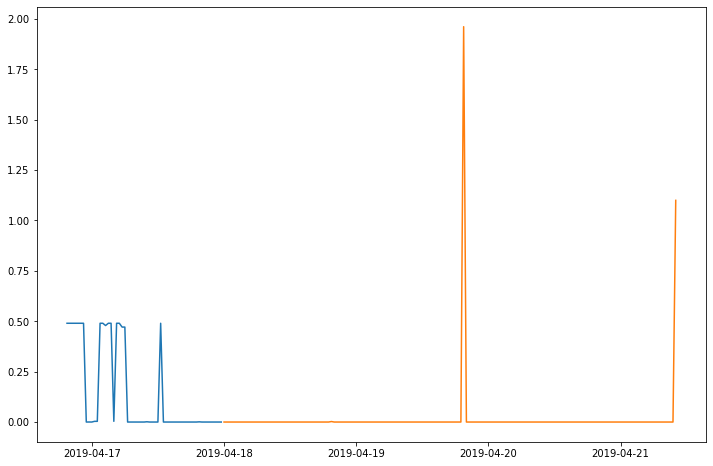

In [26]:
start_date_train = df_ts_size.head(1).index[0]
end_date_train = '2019-04-17 23:30:00'
start_date_test = '2019-04-18 00:00:00'

train = df_ts_size[:end_date_train]
test = df_ts_size[start_date_test:]

plt.figure(figsize=(12, 8))
plt.plot(train)
plt.plot(test)
plt.show()

## Simple Moving Average

In [27]:
# Calculating the short-window simple moving average
short_rolling = train.rolling(window=12).mean()

# Calculating the long-window simple moving average
long_rolling = train.rolling(window=24).mean()

In [28]:
short_rolling.head(13)

2019-04-16 19:30:00+00:00         NaN
2019-04-16 20:00:00+00:00         NaN
2019-04-16 20:30:00+00:00         NaN
2019-04-16 21:00:00+00:00         NaN
2019-04-16 21:30:00+00:00         NaN
2019-04-16 22:00:00+00:00         NaN
2019-04-16 22:30:00+00:00         NaN
2019-04-16 23:00:00+00:00         NaN
2019-04-16 23:30:00+00:00         NaN
2019-04-17 00:00:00+00:00         NaN
2019-04-17 00:30:00+00:00         NaN
2019-04-17 01:00:00+00:00    0.286391
2019-04-17 01:30:00+00:00    0.286391
Freq: 30T, Name: size_mb, dtype: float64

In [29]:
short_rolling[20:30]

2019-04-17 05:30:00+00:00    0.324983
2019-04-17 06:00:00+00:00    0.364235
2019-04-17 06:30:00+00:00    0.363944
2019-04-17 07:00:00+00:00    0.363653
2019-04-17 07:30:00+00:00    0.322825
2019-04-17 08:00:00+00:00    0.281997
2019-04-17 08:30:00+00:00    0.242107
2019-04-17 09:00:00+00:00    0.201279
2019-04-17 09:30:00+00:00    0.160451
2019-04-17 10:00:00+00:00    0.160266
Freq: 30T, Name: size_mb, dtype: float64

In [30]:
long_rolling[20:30]

2019-04-17 05:30:00+00:00         NaN
2019-04-17 06:00:00+00:00         NaN
2019-04-17 06:30:00+00:00         NaN
2019-04-17 07:00:00+00:00    0.325022
2019-04-17 07:30:00+00:00    0.304608
2019-04-17 08:00:00+00:00    0.284194
2019-04-17 08:30:00+00:00    0.263780
2019-04-17 09:00:00+00:00    0.243366
2019-04-17 09:30:00+00:00    0.222952
2019-04-17 10:00:00+00:00    0.202591
Freq: 30T, Name: size_mb, dtype: float64

**Plot the 2 window sizes for the SMA**

Text(0, 0.5, 'Size (MB)')

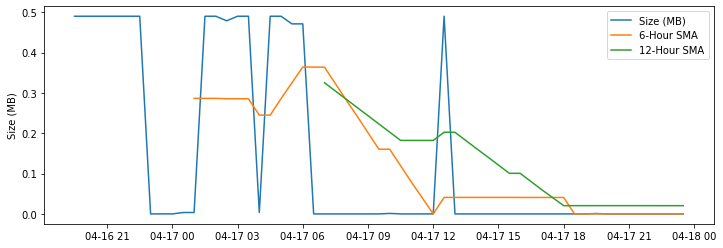

In [31]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(train.index, 
        train,
        label='Size (MB)')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = '6-Hour SMA')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = '12-Hour SMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')
# ax.xaxis.(rotate=90)
# ax.xaxis.set_major_formatter(my_datetime_fmt)

## Exponential Moving Average

SMA time series are much less noisy than the time series of the original data points. 
The challenge with SMA, however, is that the values of SMA lag the original values. This means that changes in the trend are only seen with a delay (lag) of L time units. 

Exponential Moving Average (EMA) helps reduce the lag induced by the use of the SMA. It does this by putting more weight on more recent observations, while the SMA weights all observations equally.

- M = Number of time periods, span of the window
- $t_{0}$ = Latest value
- $t-1$ = Previous value
- $EMA_{t-1}$ = Exponential moving average of previous day. 
- The multiplier: $\alpha = \frac{2}{M+1}$

- $EMA_{t}= \alpha * (t_{0} - EMA_{t-1}) + EMA_{t-1}$

Example: 
- $EMA = (current day - EMA_{previous day}) * multiplier + EMA_{previous day}$ 
- Initial SMA: 10-period sum / 10 
- Multiplier: (2 / (Time periods + 1) ) = (2 / (10 + 1) ) = 0.1818 (18.18%)

In [32]:
# Using Pandas to calculate a 2 hour span EMA. 
# adjust=False specifies that we are interested in the 
# recursive calculation mode.
ema_short = train.ewm(span=12, adjust=False).mean()
ema_short.tail()

2019-04-17 21:30:00+00:00    0.006025
2019-04-17 22:00:00+00:00    0.005098
2019-04-17 22:30:00+00:00    0.004314
2019-04-17 23:00:00+00:00    0.003650
2019-04-17 23:30:00+00:00    0.003088
Freq: 30T, Name: size_mb, dtype: float64

In [33]:
span = 24
ema_long = train.ewm(span=span, adjust=False).mean()
ema_long.tail()

2019-04-17 21:30:00+00:00    0.037941
2019-04-17 22:00:00+00:00    0.034905
2019-04-17 22:30:00+00:00    0.032113
2019-04-17 23:00:00+00:00    0.029544
2019-04-17 23:30:00+00:00    0.027180
Freq: 30T, Name: size_mb, dtype: float64

**Comparison of SMA and EMA**

Text(0, 0.5, 'Size (MB)')

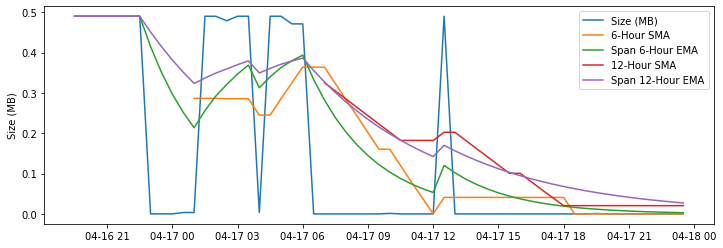

In [34]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(train.index, 
        train,
        label='Size (MB)')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = '6-Hour SMA')
ax.plot(long_rolling.index, 
        ema_short, 
        label = 'Span 6-Hour EMA')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = '12-Hour SMA')
ax.plot(long_rolling.index, 
        ema_long, 
        label = 'Span 12-Hour EMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')

## Bollinger Bands %B

%B => Percent Bandwidth
Bollinger Bands are a volatility indicator and commonly used in stock market trading. Bollinger Bands are made up of 3 lines, the Upper Band (UB), the Lower Band (LB) and the Exponential Moving Average (EMA). 
%B is an indicator derived from the Bollinger Bands. A %B > 1 indicates the data point of interest has a value above the UB, a %B < 0 indicates the data point of interest has a value below the Lower Band, and a %B of .5 indicates the data point of interest has a value that lies on the EMA. 

We need:
- Exponential Moving Average (Mid-Band)
- Window span
- Upper Band
- Lower Band

In [35]:
span = 24
ema_long = train.ewm(span=span, adjust=False).mean()
midband = ema_long[-1]
ub = midband + ema_long[-24:-1].std()*3
lb = midband - ema_long[-24:-1].std()*3

In [36]:
train.head()

2019-04-16 19:30:00+00:00    0.489937
2019-04-16 20:00:00+00:00    0.489937
2019-04-16 20:30:00+00:00    0.489937
2019-04-16 21:00:00+00:00    0.489937
2019-04-16 21:30:00+00:00    0.489937
Freq: 30T, Name: size_mb, dtype: float64

In [37]:
pct_b = pd.DataFrame({'pct_b': (train-lb)/(ub-lb)})
train = pd.DataFrame(train)

In [38]:
train = pd.concat([train, pct_b], axis=1)

**Plot**

In [39]:
train.head()

,size_mb,pct_b
2019-04-16 19:30:00+00:00,0.489937,2.266994
2019-04-16 20:00:00+00:00,0.489937,2.266994
2019-04-16 20:30:00+00:00,0.489937,2.266994
2019-04-16 21:00:00+00:00,0.489937,2.266994
2019-04-16 21:30:00+00:00,0.489937,2.266994


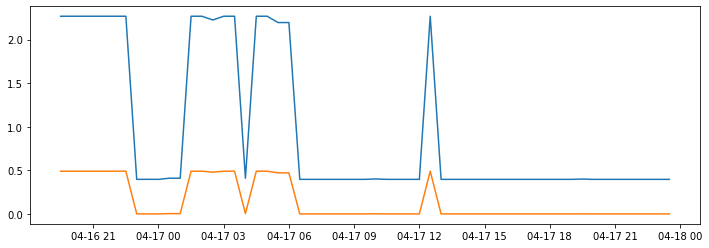

In [40]:
plt.figure(figsize=(12,4))
plt.plot(train.pct_b)
plt.plot(train.size_mb)

## Exercises

**file name:** time_series_anomaly_detection.py or time_series_anomaly_detection.ipynb

Discover users who are accessing our curriculum pages way beyond the end of their codeup time. What would the dataframe look like? Use time series method for detecting anomalies, like exponential moving average with %b.

Bonus:

Can you label students who are viewing both the web dev and data science curriculum?
Can you label students by the program they are in? 
Can you label users by student vs. staff?
What are Zach, Maggie, Faith, and Ryan's ids?